## Settings

1

In [1]:
# modify model
model = "GWTC2_powerlaw_heavy_mass"

include("utils.jl")

# modify post_events
# posts = [get_post_func(event) for event in GWTC2_events_heavy_mass];
# save("backup/posts_$(model).jld2", Dict("posts" => posts))
posts = load("backup/posts_$(model).jld2", "posts");

In [2]:
fpbh = 0.0025693801260000975 # fpbh
log_fpbh = -3
M = 8.896735628637506
α = 1.9108320383237213
i = 10
j = 30

30

## Merger rate and log_likelihood

In [3]:
function mergerRateDensity1st(i, j, M, α, fpbh)
    4.884e7* fpbh^(53/37) * (i + j)^(36/37) * (i/M)^(-α) * (j/M)^(-α) * α^3 / (i*j)^(34/37) / M^(21/37) / (M*α/(-1 + α))^(
 53/37) / (21 + 37α)
end

function mergerRateDensity2nd0(i, j, M, α, fpbh)
    if i > 2*M
        5.883e5 * fpbh^(69/37) * i^(-2α) * j^(-α) * (i+j)^(72/37) * M^(-3+3α) * α^4 * beta_func2(M/i, 1-M/i, -α, -α) * ((α-1)/α)^(69/37) / (i*j)^(31/37) / (42 + 37α)
    else
        0
    end
end

mergerRateDensity2nd(i, j, M, α, f) = 0.5 * (mergerRateDensity2nd0(i, j, M, α, f) + mergerRateDensity2nd0(j, i, M, α, f))

# function mergerRateDensity(i, j, mc, σc, f)
#     if i >= j
#         mergerRateDensity1st(i, j, mc, σc, f) + mergerRateDensity2nd(i, j, mc, σc, f)
#     else
#         mergerRateDensity(j, i, mc, σc, f)
#     end
# end

mergerRateDensity(i, j, M, α, f) = mergerRateDensity1st(i, j, M, α, f) + mergerRateDensity2nd(i, j, M, α, f)

function merger_rate(M, α, f) 
    int(m1, m2) = δm^2 * mergerRateDensity(m_min + δm*m1, m_min + δm*m2, M, α, f) 
#     println("p1=$p10, p2=$p20, p3=$p30")
    function integrand(x, f)
        f[1] = int(x[1], x[2])
    end
    result, err = cuhre(integrand, rtol=1e-3)
    0.5*result[1]
end

merger_rate (generic function with 1 method)

In [4]:
# @time mergerRateDensity(i, j, mc, σc, f)
# mergerRateDensity1st(i, j, mc, σc, f)
# @time merger_rate(mc, σc, f)
# mergerRateDensity2nd(i, j, mc, σc, f)
# @time mergerRateDensity2nd(i, j, mc, σc, f)
# @time mergerRateDensity2nd1(i, j, mc, σc, f)

In [5]:
function β_func(M, α, f)
    int0(m1, m2) = mergerRateDensity(m1, m2, M, α, f) * VT(m1, m2)
    int(m1, m2) = δm^2 * int0(m_min + δm * m1, m_min + δm * m2)
    function integrand(x, f)
        f[1] = int(x[1], x[2])
    end
    result, err = cuhre(integrand, rtol=1e-1)
    0.5 * result[1]
end

β_func (generic function with 1 method)

In [6]:
@btime β_func(M, α, fpbh)

  831.948 μs (8941 allocations: 273.97 KiB)


64.85407891930069

In [7]:
function log_pR_func(M, α, f, post)
    int0(m1, m2) = mergerRateDensity(m1, m2, M, α, f) * post(m1, m2)
    int(m1, m2) = δm^2 * int0(m_min + δm * m1, m_min + δm * m2)
    function integrand(x, f)
        f[1] = int(x[1], x[2])
    end
    result, err = cuhre(integrand, rtol=1e-1)
    log(0.5 * abs(result[1]))
end

log_pR_func (generic function with 1 method)

In [8]:
@time log_pR_func(M, α, fpbh, posts[8])

  0.081903 seconds (497.12 k allocations: 25.417 MiB, 77.73% compilation time)


-6.382856392594164

In [9]:
function logL(M, α, log_fpbh, posts)
    - β_func(M, α, 10.0^log_fpbh) + sum(log_pR_func.(M, α, 10.0^log_fpbh, posts))
end

logL (generic function with 1 method)

In [10]:
@time logL(1, 1.01, log_fpbh, posts)

  0.387241 seconds (3.02 M allocations: 147.609 MiB, 7.91% gc time, 49.77% compilation time)


-722.6043148201051

In [11]:
logL(1, 4, 0, posts)

-709.3464167389446

In [12]:
@btime logL(M, α, log_fpbh, posts)

  75.910 ms (409795 allocations: 18.62 MiB)


-505.57679259624007

In [13]:
likelihood = ps -> LogDVal(logL(ps.M, ps.α, ps.log_fpbh, posts))

prior = BAT.NamedTupleDist(
    M = (1)..(20),
    α = (1.01)..(4.0),
    log_fpbh = (-4)..(-0.0)
)

posterior = PosteriorDensity(likelihood, prior);

In [1]:
1<2 & 2>1

true

## Sampling

In [ ]:
@time begin
println("Start sampling.")

burnin = MCMCMultiCycleBurnin(max_ncycles=1000)
samples, chains = bat_sample(posterior, MCMCSampling(mcalg=MetropolisHastings(), nsteps=10^5, nchains=4, burnin = burnin));
    
println(" ")
println("Finish sampling.")
end

save("backup/samples_$model.jld2", Dict("samples" => samples, "chains" => chains))

Start sampling.


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/algotypes/bat_default.jl:44
┌ Info: Using transform algorithm PriorSubstitution()
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/chain_pool_init.jl:56


In [ ]:
@time begin
println("Start sampling.")

burnin = MCMCMultiCycleBurnin(max_ncycles=1000)
samples, chains = bat_sample(posterior, MCMCSampling(mcalg=MetropolisHastings(), nsteps=10^5, nchains=4, burnin = burnin));
    
println(" ")
println("Finish sampling.")
end

save("backup/samples_$model.jld2", Dict("samples" => samples, "chains" => chains))

Start sampling.


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/algotypes/bat_default.jl:44
┌ Info: Using transform algorithm PriorSubstitution()
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/chain_pool_init.jl:56


In [23]:
samples = load("backup/samples_$model.jld2")["samples"];

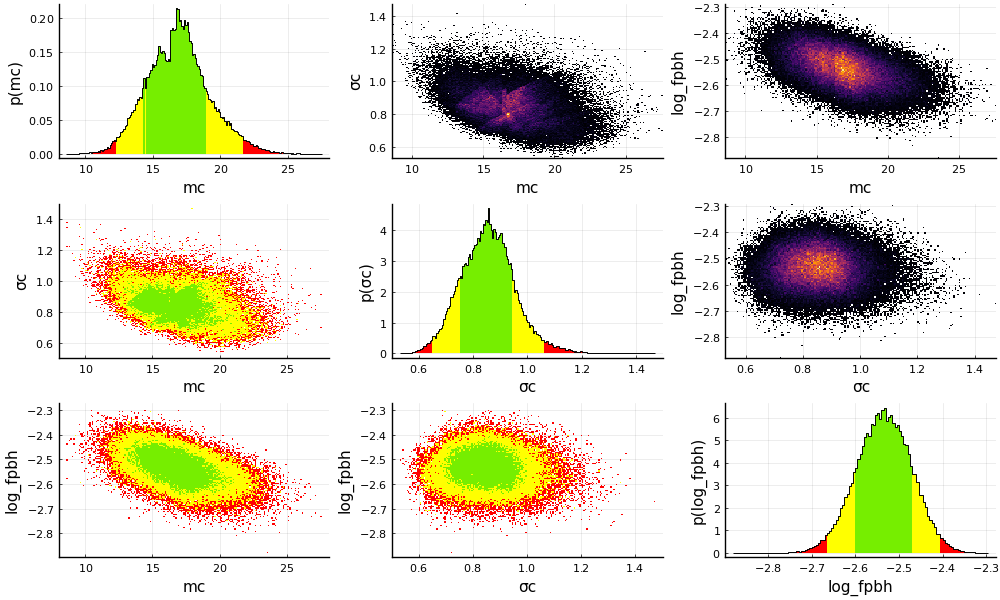

In [24]:
plot(samples)

In [ ]:
plot(
    samples, :α,
    mean = true, std = true, globalmode = true, marginalmode = true,
    nbins = 50, title = "Marginalized Distribution for y"
)

In [26]:
sd = SampledDensity(posterior, samples)
display(sd)

BAT.jl - SampledDensity
──────────────────────────────

Sampling:
─────────────────────────
total number of samples:      102814
effective number of samples: (mc = 15451.44904390591, σc = 17520.970664312077, log_fpbh = 18842.777553488366)


Parameter estimates:
─────────────────────────
number of free parameters: 3

NamedTuple{(:parameter, :mean, :std, :global_mode, :marginal_mode), Tuple{Symbol, Float64, Float64, Float64, Float64}}[(parameter = :mc, mean = 16.880571451097556, std = 2.308750596747043, global_mode = 16.77003928630452, marginal_mode = 16.75), (parameter = :σc, mean = 0.853842995325672, std = 0.10069798429779661, global_mode = 0.8042464576206975, marginal_mode = 0.8574999999999999), (parameter = :log_fpbh, mean = -2.5350287258153426, std = 0.06363490106492785, global_mode = -2.53088210975279, marginal_mode = -2.5324999999999998)]


Covariance matrix:
─────────────────────────
3×3 Named Matrix{Float64}
  cov ╲  │           mc            σc      log_fpbh
─────────┼─────────

In [27]:
get_post(para, samples) = [a[para] for a in samples.v]

get_post (generic function with 1 method)

In [28]:
log_p1_posts = get_post(:log_p1, samples)
log_p2_posts = get_post(:log_p2, samples)
log_p3_posts = get_post(:log_p3, samples)
log_p4_posts = get_post(:log_p4, samples)
log_fpbh_posts = get_post(:log_fpbh, samples)

p1_posts = 10 .^ log_p1_posts
p2_posts = 10 .^ log_p2_posts
p3_posts = 10 .^ log_p3_posts
p4_posts = 10 .^ log_p4_posts
fpbh_posts = 10 .^ log_fpbh_posts

p5_posts = get_p5.(p1_posts, p2_posts, p3_posts, p4_posts);
log_p5_posts = log10.(p5_posts);

LoadError: type NamedTuple has no field log_p1

In [29]:
p1_fpbh_posts = p1_posts .* fpbh_posts
p2_fpbh_posts = p2_posts .* fpbh_posts
p3_fpbh_posts = p3_posts .* fpbh_posts
p4_fpbh_posts = p4_posts .* fpbh_posts
p5_fpbh_posts = p5_posts .* fpbh_posts;

log_p1_fpbh_posts = log10.(p1_fpbh_posts)
log_p2_fpbh_posts = log10.(p2_fpbh_posts)
log_p3_fpbh_posts = log10.(p3_fpbh_posts)
log_p4_fpbh_posts = log10.(p4_fpbh_posts)
log_p5_fpbh_posts = log10.(p5_fpbh_posts);

LoadError: UndefVarError: p1_posts not defined

In [30]:
# R_posts = zeros(length(p1_posts))
# Threads.@threads for i in 1:length(R_posts)
#     R_posts[i] = merger_rate(p1_posts[i], p2_posts[i], p3_posts[i], p4_posts[i], fpbh_posts[i])
# end

# save("backup/R_posts_$model.jld2", Dict("samples" => R_posts))
R_posts = load("backup/R_posts_$model.jld2")["samples"];

LoadError: ArgumentError: No file exists at given path: backup/R_posts_GWTC2_lognormal_low_spin_heavy_mass.jld2

In [31]:
histogram(log_p2_posts)

LoadError: UndefVarError: log_p2_posts not defined

In [32]:
histogram(p1_fpbh_posts)

LoadError: UndefVarError: p1_fpbh_posts not defined

In [33]:
get_quantile(posts) = quantile(posts, [0.05, 0.5, 0.95])

get_quantile (generic function with 1 method)

In [34]:
function get_σ(posts)
    x_low, x_mid, x_up = get_quantile(posts)
    x_mid, max(x_up - x_mid, x_mid - x_low)
end
[1, get_σ(p1_fpbh_posts)...]

LoadError: UndefVarError: p1_fpbh_posts not defined

In [35]:
function get_interval(posts)
    x_low, x_mid, x_up = get_quantile(posts)
    x_mid, x_up - x_mid, x_mid - x_low
end

get_interval (generic function with 1 method)

In [36]:
get_interval(p1_posts)

LoadError: UndefVarError: p1_posts not defined

In [37]:
get_interval(p2_posts)

LoadError: UndefVarError: p2_posts not defined

In [38]:
get_interval(p3_posts)

LoadError: UndefVarError: p3_posts not defined

In [39]:
get_interval(p4_posts)

LoadError: UndefVarError: p4_posts not defined

In [40]:
get_interval(fpbh_posts)

LoadError: UndefVarError: fpbh_posts not defined

In [41]:
get_interval(R_posts)

LoadError: UndefVarError: R_posts not defined

In [42]:
get_quantile(R_posts)

LoadError: UndefVarError: R_posts not defined

In [43]:
function get_fpbh_from_R(p1, p2, p3, p4, q)
    func = fpbh -> merger_rate(p1, p2, p3, p4, fpbh) - quantile(R_posts, q)
    find_zero(func, (1e-4, 1e-2))
end

get_fpbh_from_R(p1, p2, p3, p4, 0.05)

LoadError: UndefVarError: p1 not defined

In [44]:
p1_qs = get_quantile(p1_posts)
p2_qs = get_quantile(p2_posts)
p3_qs = get_quantile(p3_posts)
p4_qs = get_quantile(p4_posts)
p5_qs = get_quantile(p5_posts)
fpbh_qs = get_quantile(fpbh_posts)

p1_fpbh_qs = get_quantile(p1_fpbh_posts)
p2_fpbh_qs = get_quantile(p2_fpbh_posts)
p3_fpbh_qs = get_quantile(p3_fpbh_posts)
p4_fpbh_qs = get_quantile(p4_fpbh_posts)
p5_fpbh_qs = get_quantile(p5_fpbh_posts)

LoadError: UndefVarError: p1_posts not defined

In [45]:
ps_data = [
    [(1+3)/2, get_σ(p1_fpbh_posts)...],
    [(3+10)/2, get_σ(p2_fpbh_posts)...],
    [(10+40)/2, get_σ(p3_fpbh_posts)...],
    [(40+80)/2, get_σ(p4_fpbh_posts)...],
    [(80+130)/2, get_σ(p5_fpbh_posts)...]
]

save("backup/$(model)_ps.jld2", Dict("ps" => ps_data))

LoadError: UndefVarError: p1_fpbh_posts not defined

In [46]:
function plot_band(low, mid, upper, left, right)
    ms = left:0.1:right
    pm_low = [low for m in ms]
    pm_mid = [mid for m in ms]
    pm_upper = [upper for m in ms]
    
    plot!(ms, pm_mid, label="", color="blue")
    plot!(ms, pm_low, fillrange=pm_upper, fillalpha=0.35, color="cyan", label="")
end


plot_band (generic function with 1 method)

In [47]:
# function Pm_log(σ, Mc, m)
#     1/m/σ/sqrt(2pi) * exp(- log(m/Mc)^2/2/σ^2)
# end

# best_lognormal(m) = Pm_log(0.58, 18.18, m)

# using Plots

# ms = 1:0.1:130
# ps = best_lognormal.(ms)

# plot(ms, ps, xaxis=:log, yaxis=:log, color="red", label="Log-normal", legend=:bottomleft)
# plot_band(p1_qs..., 1, 5)
# plot_band(p2_qs..., 5, 10)
# plot_band(p3_qs..., 10, 40)
# plot_band(p4_qs..., 40, 80)
# plot_band(p5_qs..., 80, 130)
# xlabel!(L"m/M_{\odot}")
# ylabel!(L"P(m)")

In [48]:
# function lognormal(σ, Mc, m)
#     1/m/σ/sqrt(2pi) * exp(- log(m/Mc)^2/2/σ^2)
# end

# best_lognormal(m) = lognormal(0.58, 18.18, m)

# using Plots

# ms = [(1+5)/2, (5+10)/2, (10+40)/2, (40+80)/2, (80+130)/2]
# ps = PmQCD.(ms, 10^(-2.26092), -0.0639596)

# plot(ms, ps, xaxis=:log, yaxis=:log, color="black", legend=:bottomleft)
# plot_band(p1_fpbh_qs..., 1, 5)
# plot_band(p2_fpbh_qs..., 5, 10)
# plot_band(p3_fpbh_qs..., 10, 40)
# plot_band(p4_fpbh_qs..., 40, 80)
# plot_band(p5_fpbh_qs..., 80, 130)
# xlabel!(L"m/M_{\odot}")
# ylabel!(L"f_\mathrm{pbh} P(m)")

In [49]:
# # using StatsPlots # no need for `using Plots` as that is reexported here
# # pyplot()
# ms = [(1+5)/2 (5+10)/2 (10+40)/2 (40+80)/2 (80+130)/2]
# ps = [p1_posts, p2_posts, p3_posts, p4_posts, p5_posts]

# violin(ms[1], ps[1], leg=false, linewidth=0, xlim=[1, 130], xaxis=:log, yaxis=:log, color="red")
# # for i in 2:5
# #     violin!(ms[i], ps[i], leg=false, linewidth=0, xlim=[1, 130], xaxis=:log, yaxis=:log, color="red", widths=1e2)
# # end
# xlabel!(L"m/M_{\odot}")
# ylabel!(L"P(m)")

In [50]:
# using StatsPlots # no need for `using Plots` as that is reexported here
# pyplot()

In [51]:
function get_err(end_points)
    left_points = end_points[1:end-1]
    right_points = end_points[2:end]
    mean_points = (left_points .+ right_points) ./ 2
    left_err = mean_points - left_points
    right_err = right_points - mean_points
    mean_points, left_err, right_err
end

get_err (generic function with 1 method)

## merger rate

In [52]:
post_190521 = get_post_func("190521")
post_200115 = get_post_func("200115_042309")
post_200105 = get_post_func("200105_162426")

post_190814 = get_post_func("190814")
post_190425 = get_post_func("190425")
post_190426 = get_post_func("190426_152155")

LoadError: ArgumentError: Cannot open 'LIGO-data/masses_source_frame_posterior/GW200115_042309_posterior.txt': not a file

In [53]:
ms = 22:0.1:27
ms2 = 2.2:0.0005:2.6
# ps = post_190814.(ms2, 1.58)
ps = post_190814.(ms, 2.5)
# ps2 = post_200115.(5.7, ms)
# ps3 = post_200105.(5.7, ms)
plot(ms, ps)
# plot!(ms, ps3)

LoadError: UndefVarError: post_190814 not defined

In [54]:
thr = 7.708648380664132e-5;
function get_area(thr, post_data)
    post, m1_min, m1_max, m2_min, m2_max = post_data
    δm1 = m1_max - m1_min
    δm2 = m2_max - m2_min
    
    function post_new(m1, m2)
        p = post(m1, m2)
        p >= thr ? p : 0
    end
    int(m1, m2) = δm1 * δm2 * post_new(m1_min + δm1*m1, m2_min + δm2*m2)
    function integrand(x, f)
        f[1] = int(x[1], x[2])
    end
    result, err = cuhre(integrand, rtol=1e-3, minevals=1e4)
    result[1]
end

function get_thr(post_data)
    fzero(thr -> get_area(thr, post_data) - 0.9, 1e-5, 1e2)
end
    
function get_cond_merger_rate(p1, p2, p3, p4, fpbh, post_data, thr)
    post, m1_min, m1_max, m2_min, m2_max = post_data
    δm1 = m1_max - m1_min
    δm2 = m2_max - m2_min
#     println(δm1)
#     println(δm2)
    
    R12_new(m1, m2) = post(m1, m2) >= thr ? R12(m1, m2, p1, p2, p3, p4, fpbh) : 0
    int(m1, m2) = δm1 * δm2 * R12_new(m1_min + δm1*m1, m2_min + δm2*m2)
#     println("p1=$p10, p2=$p20, p3=$p30")
    function integrand(x, f)
        f[1] = int(x[1], x[2])
    end
    result, err = cuhre(integrand, rtol=1e-1)
    result[1]
end

# function get_cond_merger_rate2(p1, p2, p3, p4, fpbh, post_data, thr)
#     post, m1_min, m1_max, m2_min, m2_max = post_data
#     δm1 = m1_max - m1_min
#     δm2 = m2_max - m2_min
# #     println(δm1)
# #     println(δm2)
    
#     R12_new(m1, m2) = R12(m1, m2, p1, p2, p3, p4, fpbh)
#     int(m1, m2) = δm1 * δm2 * R12_new(m1_min + δm1*m1, m2_min + δm2*m2)
# #     println("p1=$p10, p2=$p20, p3=$p30")
#     function integrand(x, f)
#         f[1] = int(x[1], x[2])
#     end
#     result, err = cuhre(integrand, rtol=1e-1)
#     result[1]
# end

get_cond_merger_rate (generic function with 1 method)

In [55]:
# post_data = [post_200105, 6, 12, 1.5, 2.5];
post_data = [post_190814, 20, 30, 1, 3];
thr = get_thr(post_data)
println(thr)
println(get_area(thr, post_data))

i = 10
@time get_cond_merger_rate(p1_posts[i], p2_posts[i], p3_posts[i], p4_posts[i], fpbh_posts[i], post_data, thr)

LoadError: UndefVarError: post_190814 not defined

In [56]:
get_cond_merger_rate(p1_qs[2], p2_qs[2], p3_qs[2], p4_qs[2], fpbh_qs[2], post_data, thr)

LoadError: UndefVarError: p1_qs not defined

In [57]:
function get_R_post(post_data)
    len = length(p1_posts)
    result = zeros(len)
    thr = get_thr(post_data)
    println(thr)
    Threads.@threads for i in 1:len
#     for i in 1:len
        result[i] = get_cond_merger_rate(p1_posts[i], p2_posts[i], p3_posts[i], p4_posts[i], fpbh_posts[i], post_data, thr)
#         println(result[i])
    end
    result
end

get_R_post (generic function with 1 method)

In [58]:
@time R_post_190521 = get_R_post([post_190521, 10, 130, 10, 130]);
save("backup/$(model)_R_post_190521.jld2", Dict("posts" => R_post_190521))

R_post = load("backup/$(model)_R_post_190521.jld2")["posts"];
get_interval(R_post)

LoadError: UndefVarError: p1_posts not defined